# Perceptron Regression for Ice Cream Revenue per Temperature

* Neural network with a single neuron working as a regressor to predict ice cream revenue given a temperature;
* Linear regressor using only one independent variable to predict a dependent variable;
* Dataset with 500 instances and 2 variables: the independent variable "Temperature", in degrees Celsius, and the dependent variable "Revenue", in dollars;
* Linear regression assumptions visually analyzed using scatter plots;
* Model built and trained using TensorFlow;
* Dataset: https://www.kaggle.com/datasets/4c8d766e253c62e5910952e619db9267f34c58497a74001571106b157080ee9b?resource=download

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,
                             r2_score,
                             mean_squared_error)

## Data Exploration and Preprocessing

Ice cream sales are positively correlated, to some degree, with temperature. Rises in temperature result in rises in revenue for ice cream vendors. With this in mind, our objective is to build a linear regression model capable of learning this correlation and predicting revenue given a temperature.

Linear regression is dependent on some assumptions for the data being used. This assumptions need to be tested before we can say that a linear regressor is suitable for a task.

After loading and showing the first 10 instances of our dataset, we can observe its overall form considering shape, data types, ranges and usual values for the variables.

Our dataset has two variables: "Temperature", the independent variable; "Revenue", the dependent variable. Both of them are of floating point type.

In [3]:
icecream_df = pd.read_csv('../data/raw/icecream_sales.csv')

icecream_df.head(10)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
5,14.352514,367.940744
6,13.707780,308.894518
7,30.833985,696.716640
8,0.976870,55.390338
9,31.669465,737.800824


Pandas' `info` method shows the number of instances in the dataset, 500, and the occurrence of null entries in it. Since the non-null count is equal to the total number of entries, the dataset does not have any null entries.

Pandas' `describe` method provides summary statistics about the data. We can see that the range of values between the two variables varies a lot. This is not an issue that requires data standardization as we are using linear regression.

In [4]:
icecream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  500 non-null    float64
 1   Revenue      500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [5]:
icecream_df.describe()

,Temperature,Revenue
count,500.000000,500.000000
mean,22.232225,521.570777
std,8.096388,175.404751
min,0.000000,10.000000
25%,17.122258,405.558681
50%,22.392791,529.368565
75%,27.740674,642.257922
max,45.000000,1000.000000


### Linear Regression Assumptions

Linear regression makes 6 main assumptions on the data to be analyzed:

1. There is a linear correlation between the independent and the dependent variables;
2. Multivariate normality, i.e., the set having all variables must follow a multivariate normal distribution;
3. No multicollinearity, meaning that indenpendent variables should not be highly correlated with each other;
4. No autocorrelation, which means that prediction errors, for any instance, must not have any correlation with prediction errors of other instances;
5. Normality of residuals, as prediction errors are assumed to follow a normal distribution;
6. Homoscedasticity, so that prediction errors have a constant variance.

If any of these 6 assumptions does not get fulfilled, it does not mean that a linear regressor cannot work on the data in question. However, the model is less guaranteed to work on real scenarios not represented by the training dataset.

### Assumption #1: Linear Correlation

To check for linear correlation between our 2 variables, we can use a scatter plot with the 2 variables plotted against each other. As we can see below, the plot forms an approximate straight line, indicating a linear correlation between the two variables. When "Temperature" increases, "Revenue" also increases.

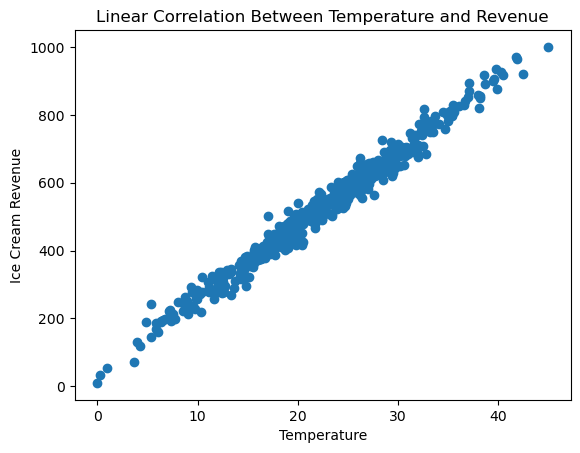

In [6]:
plt.title("Linear Correlation Between Temperature and Revenue")
plt.scatter(icecream_df['Temperature'], icecream_df['Revenue'])
plt.xlabel("Temperature")
plt.ylabel("Ice Cream Revenue")
plt.show()

### Assumption #2: Multivariate Normality

It is possible to visually evaluate the multivariate normality of a set of variables using a plot. In this plot, the x-axis is composed of the theoretical chi-squared distribution quantiles; the y-axis is composed of the squared Mahalanobis distances between every instance and the centroid of the dataset. As one can imagine, such distances are expected to follow a chi-squared distribution. In this case, a chi-squared distribution with degrees of freedom equal to the number of variables in the dataset.

`mahalanobis` implements the following formula for the squared Mahalanobis distance function:

$$
    D^2 = (u - v) \cdot cov^{-1} \cdot (u - v)^T,
$$
where:
* $D^2$ is the squared Mahalanobis distance;
* $u$ is the array to compute the distance from;
* $v$ is the array to compute the distance to;
* $cov$ is the covariance matrix of $v$.

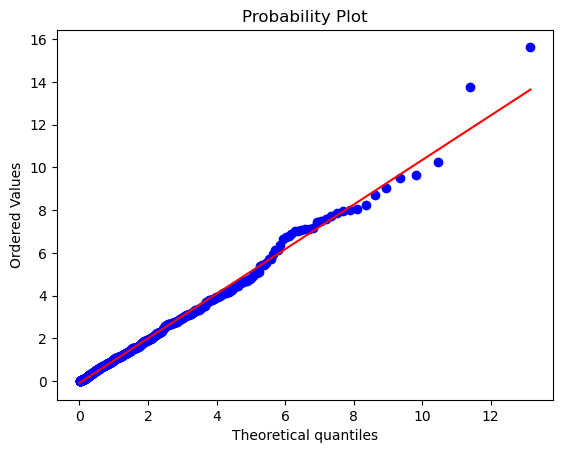

In [7]:
def mahalanobis(u, v, cov=None):
    """Function for calculating the Mahalanobis distance.

    Args:
        u (array_like): First array to measure the distance from.
        v (array_like): Second array to measure the distance to.
        cov (array_like, optional): Covariance matrix of the v array.
        Defaults to None.

    Returns:
        numpy.ndarray: Mahalanobis distance for every instance from the
        u array to the centroid of v.
    """
    if cov is None:
        cov = np.cov(v.to_numpy().T)

    u_mean_diff = u - np.mean(v, axis=0)
    inverse_cov_mat = np.linalg.inv(cov)

    mahal = np.dot(np.dot(u_mean_diff, inverse_cov_mat), u_mean_diff.T)

    return mahal.diagonal()

# Parameter sparams receives any necessary parameter for the
# theoretical distribution. In this case, degrees of freedom.
stats.probplot(mahalanobis(u = icecream_df, v = icecream_df), sparams=(2),
                           dist='chi2', plot=plt)
plt.show()

As we can visualize, the squared Mahalanobis distance measures follow the chi-squared distribution with a very good fit. Some measures start to deviate significantly only at the end of the distribution. Using this interpretation, we argue that multivariate normality is present for the set having all variables in our dataset.

### Assumption #3: No Multicollinearity

Since our dataset has only one independent variable, there is no multicollinearity in our data.

### Assumption #4: No Autocorrelation

Our dataset is not a sequence of data instances, it does not bear any relationship with a time series. Hence, each variable value is independent of previous values and no autocorrelation can occur.

---

Finally, we split our dataset into training and testing sets. The training set gets 80% of the data and the remainder is left for the testing set. The split also randomizes the data. Our dataset has only 500 instances. For this reason, there is no validation set.

In [8]:
X = icecream_df['Temperature']
y = icecream_df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

## Model Building and Training

Our linear regressor will be a simple perceptron model (which some may call an Adaline model) with only one neuron and no activation function. The output of the neuron is the predicted revenue for the input temperature. The weights of the perceptron will become the linear model's coefficients.

Since we only have 1 independent variable, our model has only 2 parameters: the coefficient for the independent variable and the intercept (or bias).

In [9]:
perceptron_regressor = tf.keras.models.Sequential()
perceptron_regressor.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
perceptron_regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Our training steps can iterate for many epochs, so we set 1000 as the maximum number of epochs. An early stopping callback with a patience of 10 is expected to intervene and stop the training phase long before epoch 1000.

Learning rate is set to a high value (0.1) to speed up the training phase. No collateral effects were observed using this learning rate.

In [10]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                           patience=10)

perceptron_regressor.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')
epochs_info = perceptron_regressor.fit(X_train, y_train, epochs=1000,
                                       callbacks=[early_stopping_callback])

Epoch 1/1000
13/13 [==============================] - 0s 5ms/step - loss: 284354.8125
Epoch 2/1000
13/13 [==============================] - 0s 923us/step - loss: 251467.3594
Epoch 3/1000
13/13 [==============================] - 0s 769us/step - loss: 221625.9844
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 194085.4531
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 169437.5000
Epoch 6/1000
13/13 [==============================] - 0s 846us/step - loss: 147049.1562
Epoch 7/1000
13/13 [==============================] - 0s 923us/step - loss: 126942.3984
Epoch 8/1000
13/13 [==============================] - 0s 846us/step - loss: 109481.3203
Epoch 9/1000
13/13 [==============================] - 0s 769us/step - loss: 93728.3125
Epoch 10/1000
13/13 [==============================] - 0s 692us/step - loss: 79797.8828
Epoch 11/1000
13/13 [==============================] - 0s 846us/step - loss: 67601.6641
Epoch 12/1000
13/13 [==================

The training loss progression presented in the plot below is very steep. Convergence is noticed long before the training stops. Anyway, it was decided to keep the learning process going as the Mean Squared Error (MSE) metric was still dropping around epoch 390.

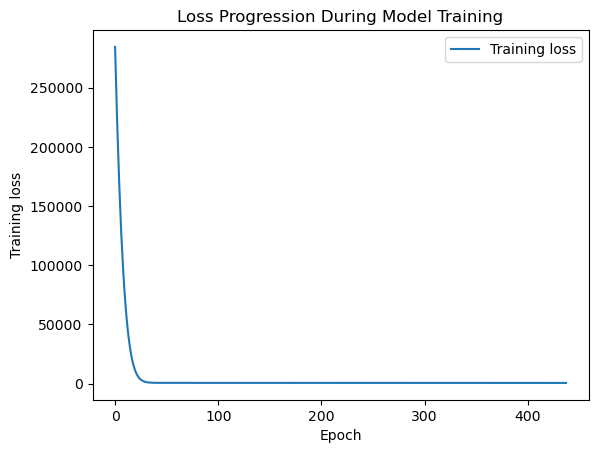

In [11]:
plt.plot(epochs_info.history['loss'])
plt.title("Loss Progression During Model Training")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.legend(["Training loss"])
plt.show()

## Model Evaluation

The linear regressor coefficients can be retrieved from the perceptron by getting its weights. The first weight is the coefficient for the only regression variable and the second weight is the constant intercept value. The model's equation is:

$$
    y = 21.709387 \cdot x + 39.081352
$$

Later, we can compare these coefficients with the ones from Scikit-learn's ordinary least squares regressor to reassure that they were fitted properly.

Below we can see 2 plots: one for the training set and one for the testing set. Set values are scattered on the plot and our regressor's regression line is drawn over them. The regression line is easily able to follow the pattern stablished by the data in both cases.

Perceptron regressor weight:  [[21.631065]]
Perceptron regressor bias:  [41.016247]


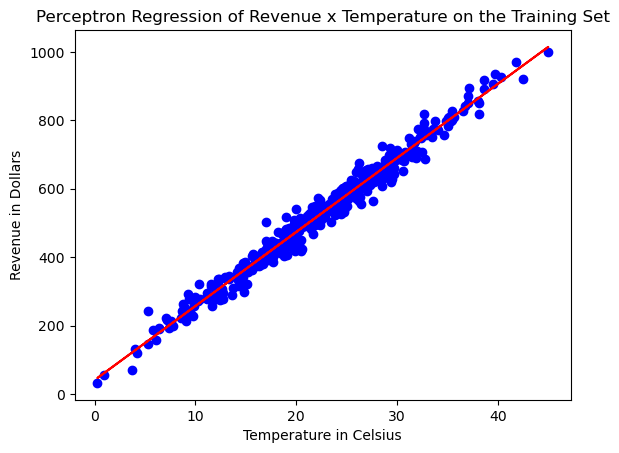

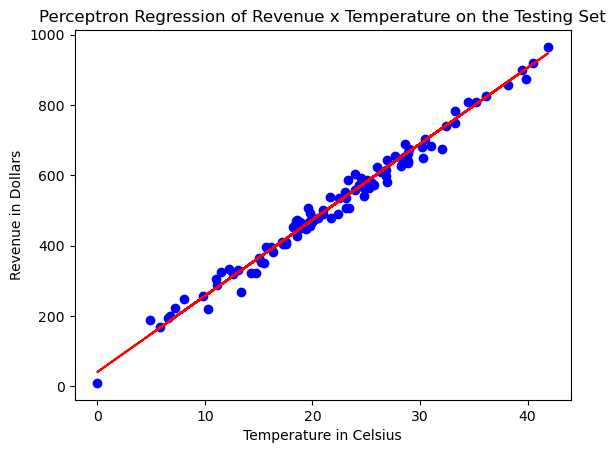

In [12]:
print("Perceptron regressor weight: ", perceptron_regressor.get_weights()[0])
print("Perceptron regressor bias: ", perceptron_regressor.get_weights()[1])

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train, perceptron_regressor.predict(X_train), color='r')
plt.title("Perceptron Regression of Revenue x Temperature on the Training Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

plt.scatter(X_test, y_test, color='b')
plt.plot(X_test, perceptron_regressor.predict(X_test), color='r')
plt.title("Perceptron Regression of Revenue x Temperature on the Testing Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

### Assumption #5: Normality of Residuals

The 5th assumption linear regression makes is that prediction errors are Gaussian-distributed. We can check that by plotting the theoretical quantiles of a normal distribution on the x-axis and the sorted residuals on the y-axis.

The plotted points mostly follow the diagonal line. Therefore, we conclude that the prediction errors of our perceptron do follow a normal distribution.

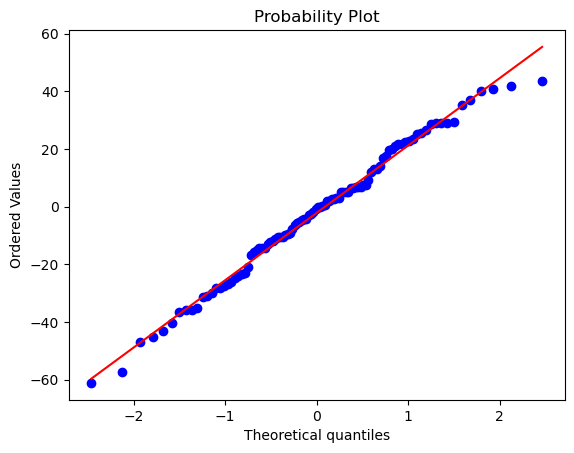

In [13]:
X_test_prediction = perceptron_regressor.predict(X_test).ravel()
X_test_residuals = y_test - X_test_prediction

stats.probplot(X_test_residuals, dist='norm', plot=plt)
plt.show()

### Assumption #6: Homoscedasticity

The last linear regression assumption says that prediction errors should maintain the same variance across all predictions. If we plot the predicted values on the x-axis and the residuals on the y-axis, it becomes clear that there is a single variance: all points are randomly scattered, not forming more than one pattern. The horizontal line is in the plot just for reference.

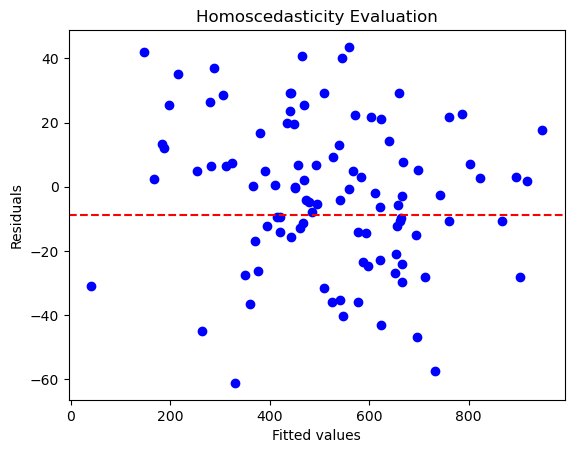

In [14]:
midpoint = (np.max(X_test_residuals) + np.min(X_test_residuals)) / 2

plt.title("Homoscedasticity Evaluation")
plt.scatter(X_test_prediction, X_test_residuals, color='b')
plt.axhline(midpoint, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

We can compare our perceptron regressor with Scikit-learn's Ordinary Least Squares (OLS) regressor to double check the model's performance. After instantianting the OLS regressor with its default parameters, we train it on the reshaped data. With the coefficients, we get the following model equation:

$$
y = 21.5133908 \cdot x + 43.73357869
$$

The independent variable coefficient is almost the same as the one for the perceptron regressor. The intercept, on the other hand, is a bit different.

Lastly, we can check how well the OLS regressor fits the training and testing sets. In the next plots, data points are scattered in space and the regression line is drawn over the plot. The regression line is able to correctly represent the data.

Linear regression coefficient:  [[21.5133908]]
Linear regression intercept:  [43.73357869]


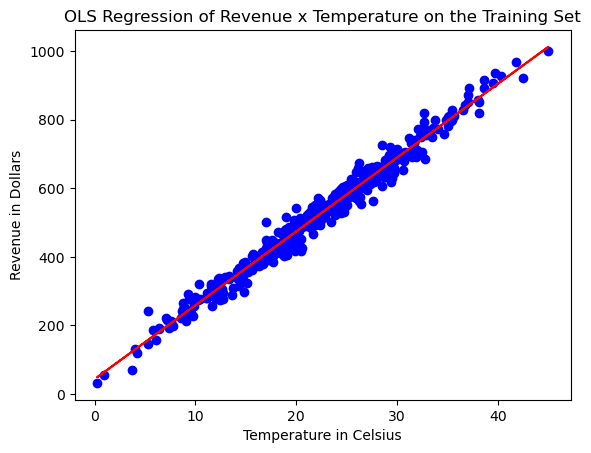

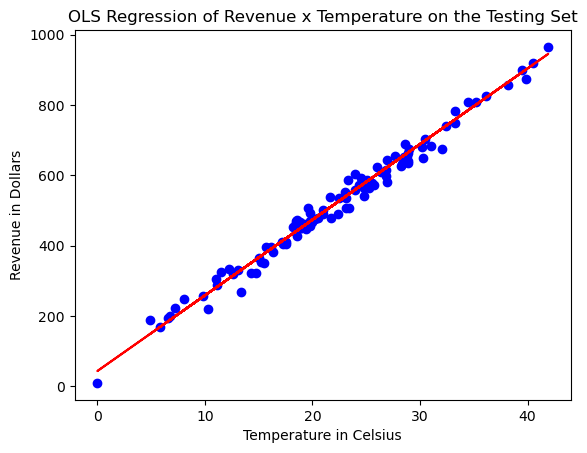

In [15]:
# Convert and reshape Pandas dataframes to sklearn input standard.
X_train_reshaped = X_train.to_numpy().reshape(-1, 1)
y_train_reshaped = y_train.to_numpy().reshape(-1, 1)
X_test_reshaped = X_test.to_numpy().reshape(-1, 1)
y_test_reshaped = y_test.to_numpy().reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_reshaped, y_train_reshaped)

print("Linear regression coefficient: ", linear_regressor.coef_)
print("Linear regression intercept: ", linear_regressor.intercept_)

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train_reshaped, linear_regressor.predict(X_train_reshaped),
         color='r')
plt.title("OLS Regression of Revenue x Temperature on the Training Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

plt.scatter(X_test, y_test, color='b')
plt.plot(X_test_reshaped, linear_regressor.predict(X_test_reshaped),
         color='r')
plt.title("OLS Regression of Revenue x Temperature on the Testing Set")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

Mean Absolute Error (MAE), R2 score and Mean Squared Error (MAE) metrics are used to get quantitative performance evaluations for both regressors. These performance metrics point out almost the same performance for both regressors. Scikit-learn's OLS regressor performs slightly better, but without significant differences.

In [22]:
print("Perceptron Regressor Performance Measures")
print("Mean squared error: ", mean_squared_error(y_test,
                                                       X_test_prediction))
print("R2 score: ", r2_score(y_test, X_test_prediction))
print("Mean absolute error: ", mean_absolute_error(y_test, X_test_prediction))
print()

OLS_X_test_prediction = linear_regressor.predict(X_test_reshaped)
print("OLS Regressor Performance Measures")
print("Mean squared error: ", mean_squared_error(y_test, 
                                                       OLS_X_test_prediction))
print("R2 score: ", r2_score(y_test, OLS_X_test_prediction))
print("Mean absolute error: ", mean_absolute_error(y_test, OLS_X_test_prediction))

Perceptron Regressor Performance Measures
Mean squared error:  534.1235663326488
R2 score:  0.9835504600695195
Mean absolute error:  18.444811819413573

OLS Regressor Performance Measures
Mean squared error:  528.2150684519345
R2 score:  0.9837324255882576
Mean absolute error:  18.3032135301029


To close our analysis, we can pass a random temperature in degrees Celsius to both models and check how well they predict the known actual value. Both regressors predict almost the same value and both of them miss by a small margin of around 22 dollars. This small error margin is consistent with the small MAE errors observed on testing data.

We conclude that our simple regressor, created using a single neuron, predicts revenue in this dataset with a near-perfect performance of 0.98 in R2 score (maximum is 1.0). The perceptron regressor also has almost the exact same performance as the OLS regressor from Scikit-learn.

In [23]:
temperature_test = 26

print("Perceptron regressor predicted revenue: ",
      np.round(perceptron_regressor.predict([temperature_test]), 2))
print("Ordinary least squares regressor predicted revenue: ",
      np.round(linear_regressor.predict([[temperature_test]])))
print("Actual revenue: ", icecream_df.iloc[1, 1])

Perceptron regressor predicted revenue:  [[603.42]]
Ordinary least squares regressor predicted revenue:  [[603.]]
Actual revenue:  625.1901215
